In [1]:
import configparser
import pandas as pd
import matplotlib.pyplot as plt

from pyspn.components import spn_visualization, spn_io

from components.ModelExtractor import ModelExtractor
from components.ModelValidator import ModelValidator
from components.ModelManipulator import ModelManipulator

In [2]:
config = configparser.ConfigParser()
config.read('cs_two_station.ini')

event_log = pd.read_csv('raw_data/cs_two_station/event_log.csv', sep=";", converters={"order_id":str}, parse_dates=["timestamp"], dayfirst=True)
state_log = pd.read_csv('raw_data/cs_two_station/state_log.csv', sep=";", parse_dates=["timestamp"], dayfirst=True)
event_log_unseen = pd.read_csv('raw_data/cs_two_station/event_log_unseen.csv', sep=";", converters={"order_id":str}, parse_dates=["timestamp"], dayfirst=True)
state_log_unseen = pd.read_csv('raw_data/cs_two_station/state_log_unseen.csv', sep=";", parse_dates=["timestamp"], dayfirst=True)

In [3]:
mg = ModelExtractor(event_log, state_log, config)
rel_model = mg.extract_model()

Discover material flow model
Determine immediate transition firing weights
Determine arrival transitions & fit distributions


c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]
Fitting 7 distributions: 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


Determine timed transitions & fit distributions


Fitting 7 distributions: 100%|██████████| 7/7 [00:00<00:00,  8.09it/s]


Determine resource capacities/buffer sizes & add inhibitor arcs to model
Create resource failure models & fit failure and repair distributions


Fitting 7 distributions: 100%|██████████| 7/7 [00:00<00:00, 20.17it/s]


<Figure size 640x480 with 0 Axes>

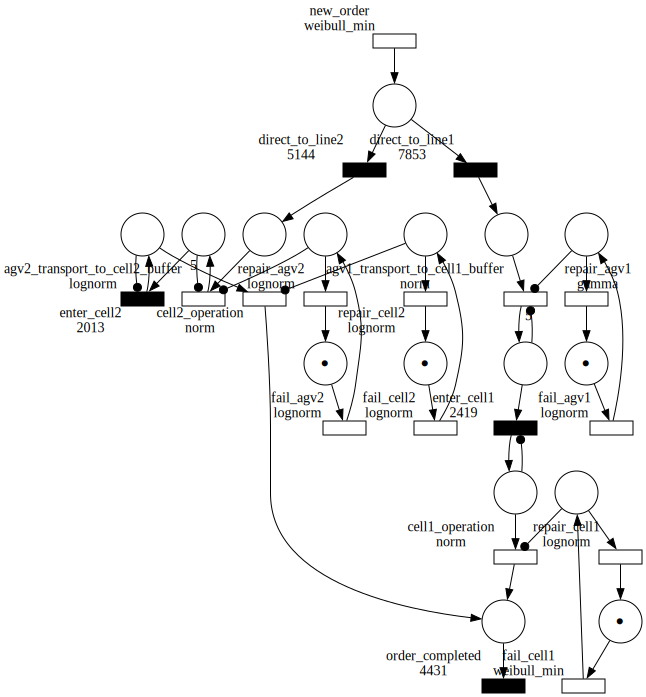

In [4]:
spn_visualization.draw_spn(rel_model, show=False, print_place_labels=False, rankdir="TB")

In [5]:
#spn_io.export_spn(rel_model, "cs_two_station.pkl")

In [6]:
#rel_model = spn_io.import_spn("output/models/cs_two_station.pkl")

In [7]:
mv = ModelValidator(rel_model,"m",event_log,state_log,event_log_unseen,state_log_unseen)
ci, y_mean, gt_ci, gt_mean, gt_ci_unseen, gt_mean_unseen = mv.validate_model(nr_replications=100, time = 1440, results_transition="order_completed", kpi="production volume")

--- SIMULATION RESULTS --- 

Y: [158, 154, 170, 126, 146, 156, 132, 165, 168, 159, 149, 147, 146, 149, 164, 145, 139, 158, 142, 148, 164, 160, 165, 144, 151, 150, 160, 128, 149, 156, 138, 145, 153, 143, 168, 134, 144, 143, 135, 155, 154, 136, 147, 133, 126, 168, 136, 157, 158, 154, 143, 142, 178, 146, 161, 143, 146, 167, 151, 149, 161, 137, 146, 152, 142, 149, 148, 144, 144, 148, 159, 150, 174, 157, 157, 161, 131, 151, 143, 149, 148, 149, 140, 152, 143, 141, 142, 137, 142, 136, 146, 138, 134, 138, 150, 173, 176, 132, 160, 157]
Mean: 149.38
Variance: 128.12
Standard deviation: 11.32
CI: (147.13409106916913, 151.62590893083086)

--- GROUND TRUTH --- 

n: 30
Y: [156, 130, 155, 162, 138, 139, 148, 144, 142, 172, 147, 144, 139, 153, 146, 159, 136, 141, 164, 130, 164, 146, 141, 144, 164, 125, 162, 151, 154, 135]
Mean: 147.7
CI: (143.32537978531985, 152.07462021468012)

--- GROUND TRUTH UNSEEN --- 

n: 30
Y: [151, 151, 141, 138, 165, 145, 146, 142, 138, 154, 144, 149, 169, 157, 151, 140, 152,

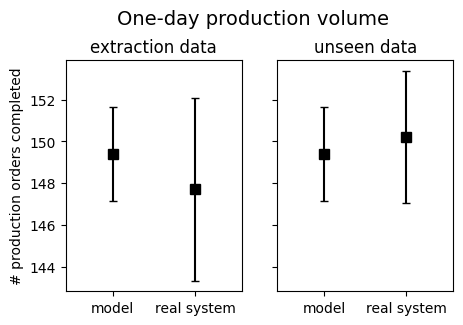

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 3), sharey=True)
fig.suptitle('One-day production volume', fontsize=14, y=1.05)

ax1.set_xlim(right = 3, left = 0)
ax1.set_xticks([0.8, 2.2], ['model', 'real system'])
ax1.set_title("extraction data")
ax1.set_ylabel("# production orders completed")

ax1.errorbar(x=0.8,y=y_mean,yerr=(ci[1]-ci[0])/2,color="black", capsize=3,linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")
ax1.errorbar(x=2.2,y=gt_mean,yerr=(gt_ci[1]-gt_ci[0])/2,color="black", capsize=3,linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")

ax2.set_xlim(right = 3, left = 0)
ax2.set_xticks([0.8, 2.2], ['model', 'real system'])
ax2.set_title("unseen data")

ax2.errorbar(x=0.8,y=y_mean,yerr=(ci[1]-ci[0])/2,color="black", capsize=3,linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")
ax2.errorbar(x=2.2,y=gt_mean_unseen,yerr=(gt_ci_unseen[1]-gt_ci_unseen[0])/2,color="black", capsize=3,linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")

#fig.savefig("validation1.pdf", format="pdf", bbox_inches="tight")

In [13]:
ci_downtime, y_mean_downtime, gt_ci_downtime, gt_mean_downtime, gt_ci_downtime_unseen, gt_mean_downtime_unseen = mv.validate_model(nr_replications=100, time = 1440, results_transition=["repair_agv1","repair_agv2","repair_cell1","repair_cell2"], kpi="resource downtime")

--- SIMULATION RESULTS --- 

Y: [2598.44680791141, 2758.855490315658, 2880.8168328374104, 2802.217279804015, 2809.85764582449, 2822.7179629016828, 2962.4850909871357, 2730.611424266143, 2905.806976743505, 2795.7239809051357, 2746.5998409536774, 2821.67581538209, 2744.2587329560365, 2834.6498042596695, 2745.5270896821585, 2804.691040312935, 2678.3870469097724, 2879.5477734744554, 2854.3736971319604, 2676.2900501663207, 2879.2905759801997, 2651.857129912777, 2735.068865123833, 2723.30192835273, 2766.9760193650613, 2720.617578999833, 2853.5453710594024, 2986.3240641944863, 2753.4635692096053, 2673.3556455553985, 2802.5433638440645, 2936.626245454675, 2870.953546920757, 2907.8296792349447, 2764.937375048614, 2672.0145680113055, 2673.6149498682626, 2759.4702917945247, 2712.169027471077, 2880.4596480446994, 2785.3435562804734, 2956.272564139997, 2821.214658031141, 2830.449608634071, 2781.3765819747296, 2924.595480907848, 2753.51820161551, 2929.6685254884374, 2749.9872135978294, 2718.11722571

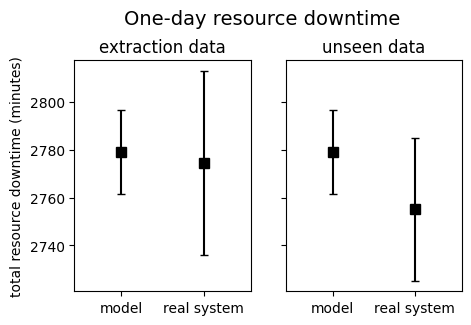

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 3), sharey=True)
fig.suptitle('One-day resource downtime', fontsize=14, y=1.05)

ax1.set_xlim(right = 3, left = 0)
ax1.set_xticks([0.8, 2.2], ['model', 'real system'])
ax1.set_title("extraction data")
ax1.set_ylabel("total resource downtime (minutes)")

ax1.errorbar(x=0.8,y=y_mean_downtime,yerr=(ci_downtime[1]-ci_downtime[0])/2,color="black", capsize=3,linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")
ax1.errorbar(x=2.2,y=gt_mean_downtime,yerr=(gt_ci_downtime[1]-gt_ci_downtime[0])/2,color="black", capsize=3,linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")

ax2.set_xlim(right = 3, left = 0)
ax2.set_xticks([0.8, 2.2], ['model', 'real system'])
ax2.set_title("unseen data")

ax2.errorbar(x=0.8,y=y_mean_downtime,yerr=(ci_downtime[1]-ci_downtime[0])/2,color="black", capsize=3,linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")
ax2.errorbar(x=2.2,y=gt_mean_downtime_unseen,yerr=(gt_ci_downtime_unseen[1]-gt_ci_downtime_unseen[0])/2,color="black", capsize=3,linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")

#fig.savefig("validation2.pdf", format="pdf", bbox_inches="tight")

In [11]:
mm = ModelManipulator(rel_model, time_unit="m")
new_config_downtime = mm.manipulate_model(time = 1440, results_transition=["repair_agv1","repair_agv2","repair_cell1","repair_cell2"], kpi = "resource repair time", transitions_to_manipulate_dynamic=["repair_agv1","repair_agv2","repair_cell1","repair_cell2"], handicap_range_dynamic = [1.0,3.1], step_dynamic = 0.2,nr_replications=30, type_dynamic="decrease")
new_config_prod_vol = mm.manipulate_model(time = 1440, results_transition=["order_completed"], kpi = "production volume", transitions_to_manipulate_dynamic=["repair_agv1","repair_agv2","repair_cell1","repair_cell2"], handicap_range_dynamic = [1.0,3.1], step_dynamic = 0.2,nr_replications=30, type_dynamic="decrease")

Text(0, 0.5, '# production orders completed')

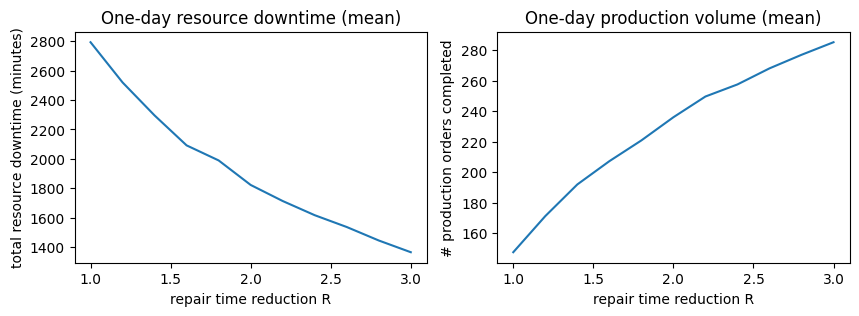

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(new_config_downtime.keys(),new_config_downtime.values())
ax1.set_title("One-day resource downtime (mean)")
ax1.set_xlabel("repair time reduction R")
ax1.set_ylabel("total resource downtime (minutes)")

ax2.plot(new_config_prod_vol.keys(),new_config_prod_vol.values())
ax2.set_title("One-day production volume (mean)")
ax2.set_xlabel("repair time reduction R")
ax2.set_ylabel("# production orders completed")

#fig.savefig("scenario1.pdf", format="pdf", bbox_inches="tight")